# Path Integrating Recurrent Neural Network

## Set up

In [147]:
# autoreload
%load_ext autoreload
%autoreload 2
# jupyter black formatter
%load_ext jupyter_black

import subprocess
import os
import sys

gitroot_path = subprocess.check_output(
    ["git", "rev-parse", "--show-toplevel"], universal_newlines=True
)

os.chdir(os.path.join(gitroot_path[:-1], "pirnns"))
print("Working directory: ", os.getcwd())

sys_dir = os.path.dirname(os.getcwd())
sys.path.append(sys_dir)
print("Directory added to path: ", sys_dir)
sys.path.append(os.getcwd())
print("Directory added to path: ", os.getcwd())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black
Working directory:  /Users/facosta/code/pirnns/pirnns
Directory added to path:  /Users/facosta/code/pirnns
Directory added to path:  /Users/facosta/code/pirnns/pirnns


## Instantiate the task datamodule

The datamodule is responsible for loading the training and validation datasets.

This defines the inputs and outputs of the neural computation.

In [148]:
from datamodule import PathIntegrationDataModule

datamodule = PathIntegrationDataModule(
    num_trajectories=1000,
    batch_size=128,
    num_workers=7,
    train_val_split=0.8,
    start_time=0,
    end_time=100,
    num_time_steps=1000,
    arena_L=5,
    mu_speed=0.2,
    sigma_speed=0.5,
    tau_vel=1,
)
datamodule.setup()

### Visualize example trajectory

/var/folders/8b/kfw1m18s7wsbzj2w7s172dxh0000gn/T/ipykernel_9086/2285876287.py:12: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)

/var/folders/8b/kfw1m18s7wsbzj2w7s172dxh0000gn/T/ipykernel_9086/2285876287.py:13: DeprecationWarning:

__array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)



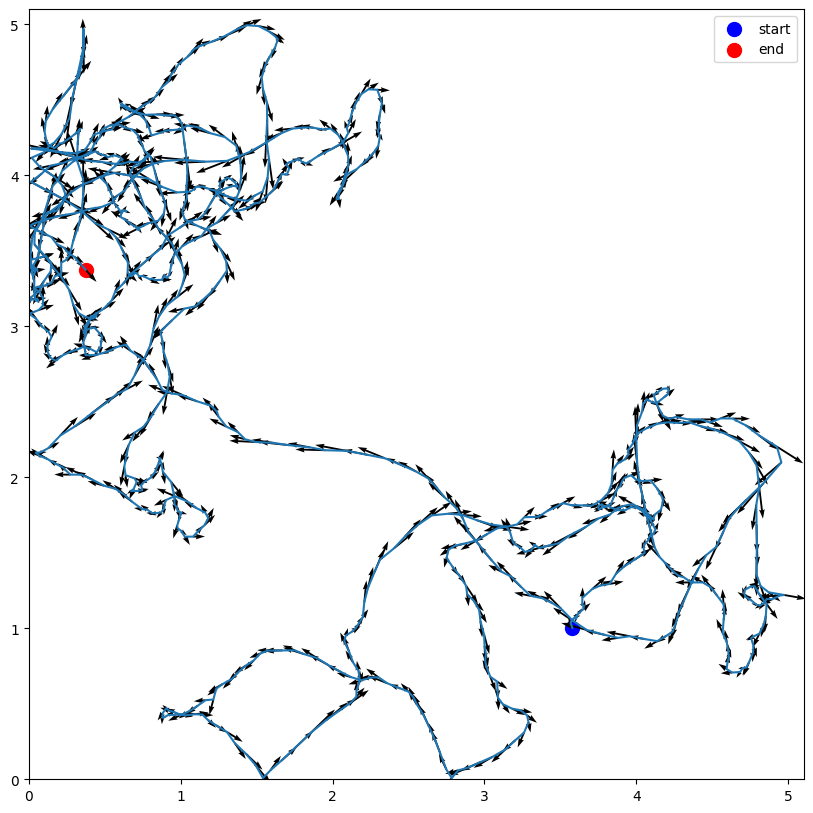

In [149]:
import numpy as np
import matplotlib.pyplot as plt

loader = datamodule.train_dataloader()
batch_inputs, batch_positions = next(iter(loader))

positions = batch_positions[0, :, :]

head_directions = batch_inputs[0, :, 0]
speeds = batch_inputs[0, :, 1]

v_x = speeds * np.cos(head_directions)
v_y = speeds * np.sin(head_directions)


plt.figure(figsize=(10, 10))
# set limits
plt.xlim(0, 5.1)
plt.ylim(0, 5.1)

# plot start and end points
plt.scatter(positions[0, 0], positions[0, 1], color="blue", label="start", s=100)
plt.scatter(positions[-1, 0], positions[-1, 1], color="red", label="end", s=100)
plt.legend()

# plot trajectories
plt.plot(positions[:, 0], positions[:, 1])

# plot velocity vectors
plt.quiver(positions[:, 0], positions[:, 1], v_x, v_y)
plt.show();

## Instantiate the model to be trained on the task

In [150]:
from pirnns.model import PathIntRNN

model = PathIntRNN(
    input_size=2,
    hidden_size=50,
    output_size=2,
    alpha=0.9,
)

print(model)

# print the number of parameters
print("Number of trainable parameters: ", sum(p.numel() for p in model.parameters()))

PathIntRNN(
  (rnn_step): RNNStep(
    (activation): Tanh()
    (W_in): Linear(in_features=2, out_features=50, bias=True)
    (W_rec): Linear(in_features=50, out_features=50, bias=True)
  )
  (W_out): Linear(in_features=50, out_features=2, bias=True)
  (W_h_init): Linear(in_features=2, out_features=50, bias=True)
)
Number of trainable parameters:  2952


## Instantiate the lightning module and Trainer

The model lightning module is responsible for implementing the training and validation steps.

This involves defining the loss function, the optimizer, and the learning rate scheduler.

The trainer is responsible for training the model.

In [ ]:
from pirnns.model_lightning import PathIntRNNLightning
import torch

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)

rnn_lightning = PathIntRNNLightning(model=model, lr=0.01)


print("Training on device: ", device)

rnn_lightning.model.to(device)

print(rnn_lightning)

Training on device:  mps
PathIntRNNLightning(
  (model): PathIntRNN(
    (rnn_step): RNNStep(
      (activation): Tanh()
      (W_in): Linear(in_features=2, out_features=50, bias=True)
      (W_rec): Linear(in_features=50, out_features=50, bias=True)
    )
    (W_out): Linear(in_features=50, out_features=2, bias=True)
    (W_h_init): Linear(in_features=2, out_features=50, bias=True)
  )
)


## Train the model

In [156]:
import lightning as L

trainer = L.Trainer(
    max_epochs=5,
    logger=False,
    num_sanity_val_steps=0,
)

train_loader = datamodule.train_dataloader()
val_loader = datamodule.val_dataloader()

trainer.fit(rnn_lightning, train_loader, val_loader)

INFO: Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:lightning.pytorch.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO: GPU available: True (mps), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (mps), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | model | PathIntRNN | 3.0 K  | train
---------------------------------------------
3.0 K     Trainable params
0         Non-trainable params
3.0 K     Total param

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: `Trainer.fit` stopped: `max_epochs=5` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


## Visualize training and validation loss

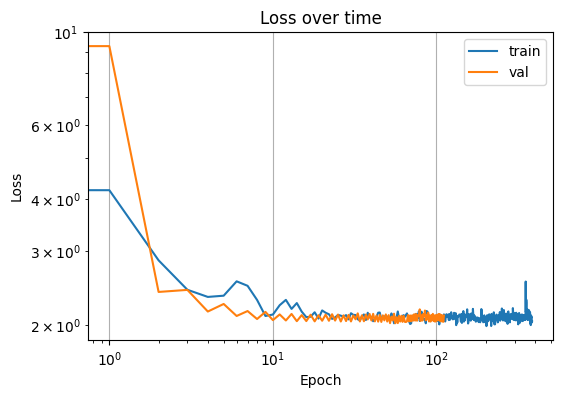

In [157]:
train_losses = [
    train_loss.detach().cpu().numpy() for train_loss in rnn_lightning.train_losses
]
val_losses = [val_loss.detach().cpu().numpy() for val_loss in rnn_lightning.val_losses]

plt.figure(figsize=(6, 4))
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over time")
plt.grid(True)
plt.yscale("log")
plt.xscale("log")
plt.legend()
plt.show()

## Save the model weights

In [161]:
torch.save(model.state_dict(), "model_weights/model_weights.pth")